## EEE485 - Project Phase I

### Imports

In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.linalg as LA
import smote
import random
import kNN
import fcn
#from logistic_regression import logistic_regression

### Load Data

In [2]:
raw_data = pd.read_csv("data.csv")
bankrupt_pd = raw_data["Bankrupt?"]
features_pd = raw_data.drop(["Bankrupt?"], axis=1)
raw_data

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                           0.370594          
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       ROA(A) before interest and % after tax  \
0                                    0.424389   
1                                    0.538214   
2                                    0.499019   
3                                    0.451265   
4                                    0.538432   
...                                       ...   
6814                                 0.539468   
6815                                 0.538269   
6816                                 0.533744   
6817                                 0.559911   
6818                                 0.570105   

       ROA(B) before interest and depreciation after tax  \
0                                              0.405750    
1                                              0.516730    
2                                              0.472295    
3                                              0.457733    
4                                              0.522298    
...                                                 ...    
6814                                           0.543230    
6815                                           0.524172    
6816                                           0.520638    
6817                                           0.554045    
6818                                           0.549548    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                    0.601457                      0.601457   
1                    0.610235                      0.610235   
2                    0.601450                      0.601364   
3                    0.583541                      0.583541   
4                    0.598783                      0.598783   
...                       ...                           ...   
6814                 0.604455                      0.604462   
6815                 0.598308                      0.598308   
6816                 0.610444                      0.610213   
6817                 0.607850                      0.607850   
6818                 0.627409                      0.627409   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.998969                    0.796887   
1                   0.998946                    0.797380   
2                   0.998857                    0.796403   
3                   0.998700                    0.796967   
4                   0.998973                    0.797366   
...                      ...                         ...   
6814                0.998992                    0.797409   
6815                0.998992                    0.797414   
6816                0.998984                    0.797401   
6817                0.999074                    0.797500   
6818                0.998080                    0.801987   

       After-tax net Interest Rate  \
0                         0.808809   
1                         0.809301   
2                         0.808388   
3                         0.808966   
4                         0.809304   
...                            ...   
6814                      0

### Check for NAN and Duplicate Values


In [3]:
print("NAN values:", [col for col in features_pd if features_pd[col].isna().sum() > 0])
print("Duplicates:", features_pd.duplicated().sum())

NAN values: []
Duplicates: 0


We now know that we do not have any missing or duplicate data

### Evaluate Data Imbalance

In [4]:
unstable_initial = (raw_data["Bankrupt?"] == 1).sum()
stable_initial = (raw_data["Bankrupt?"] == 0).sum()
print("Data Size:", raw_data.shape[0])
print("# of stable companies:", stable_initial )
print("# of unstable companies:", unstable_initial )
print("Unstable to Stable Ratio: ", unstable_initial/stable_initial)

Data Size: 6819
# of stable companies: 6599
# of unstable companies: 220
Unstable to Stable Ratio:  0.03333838460372784


### PLOTS

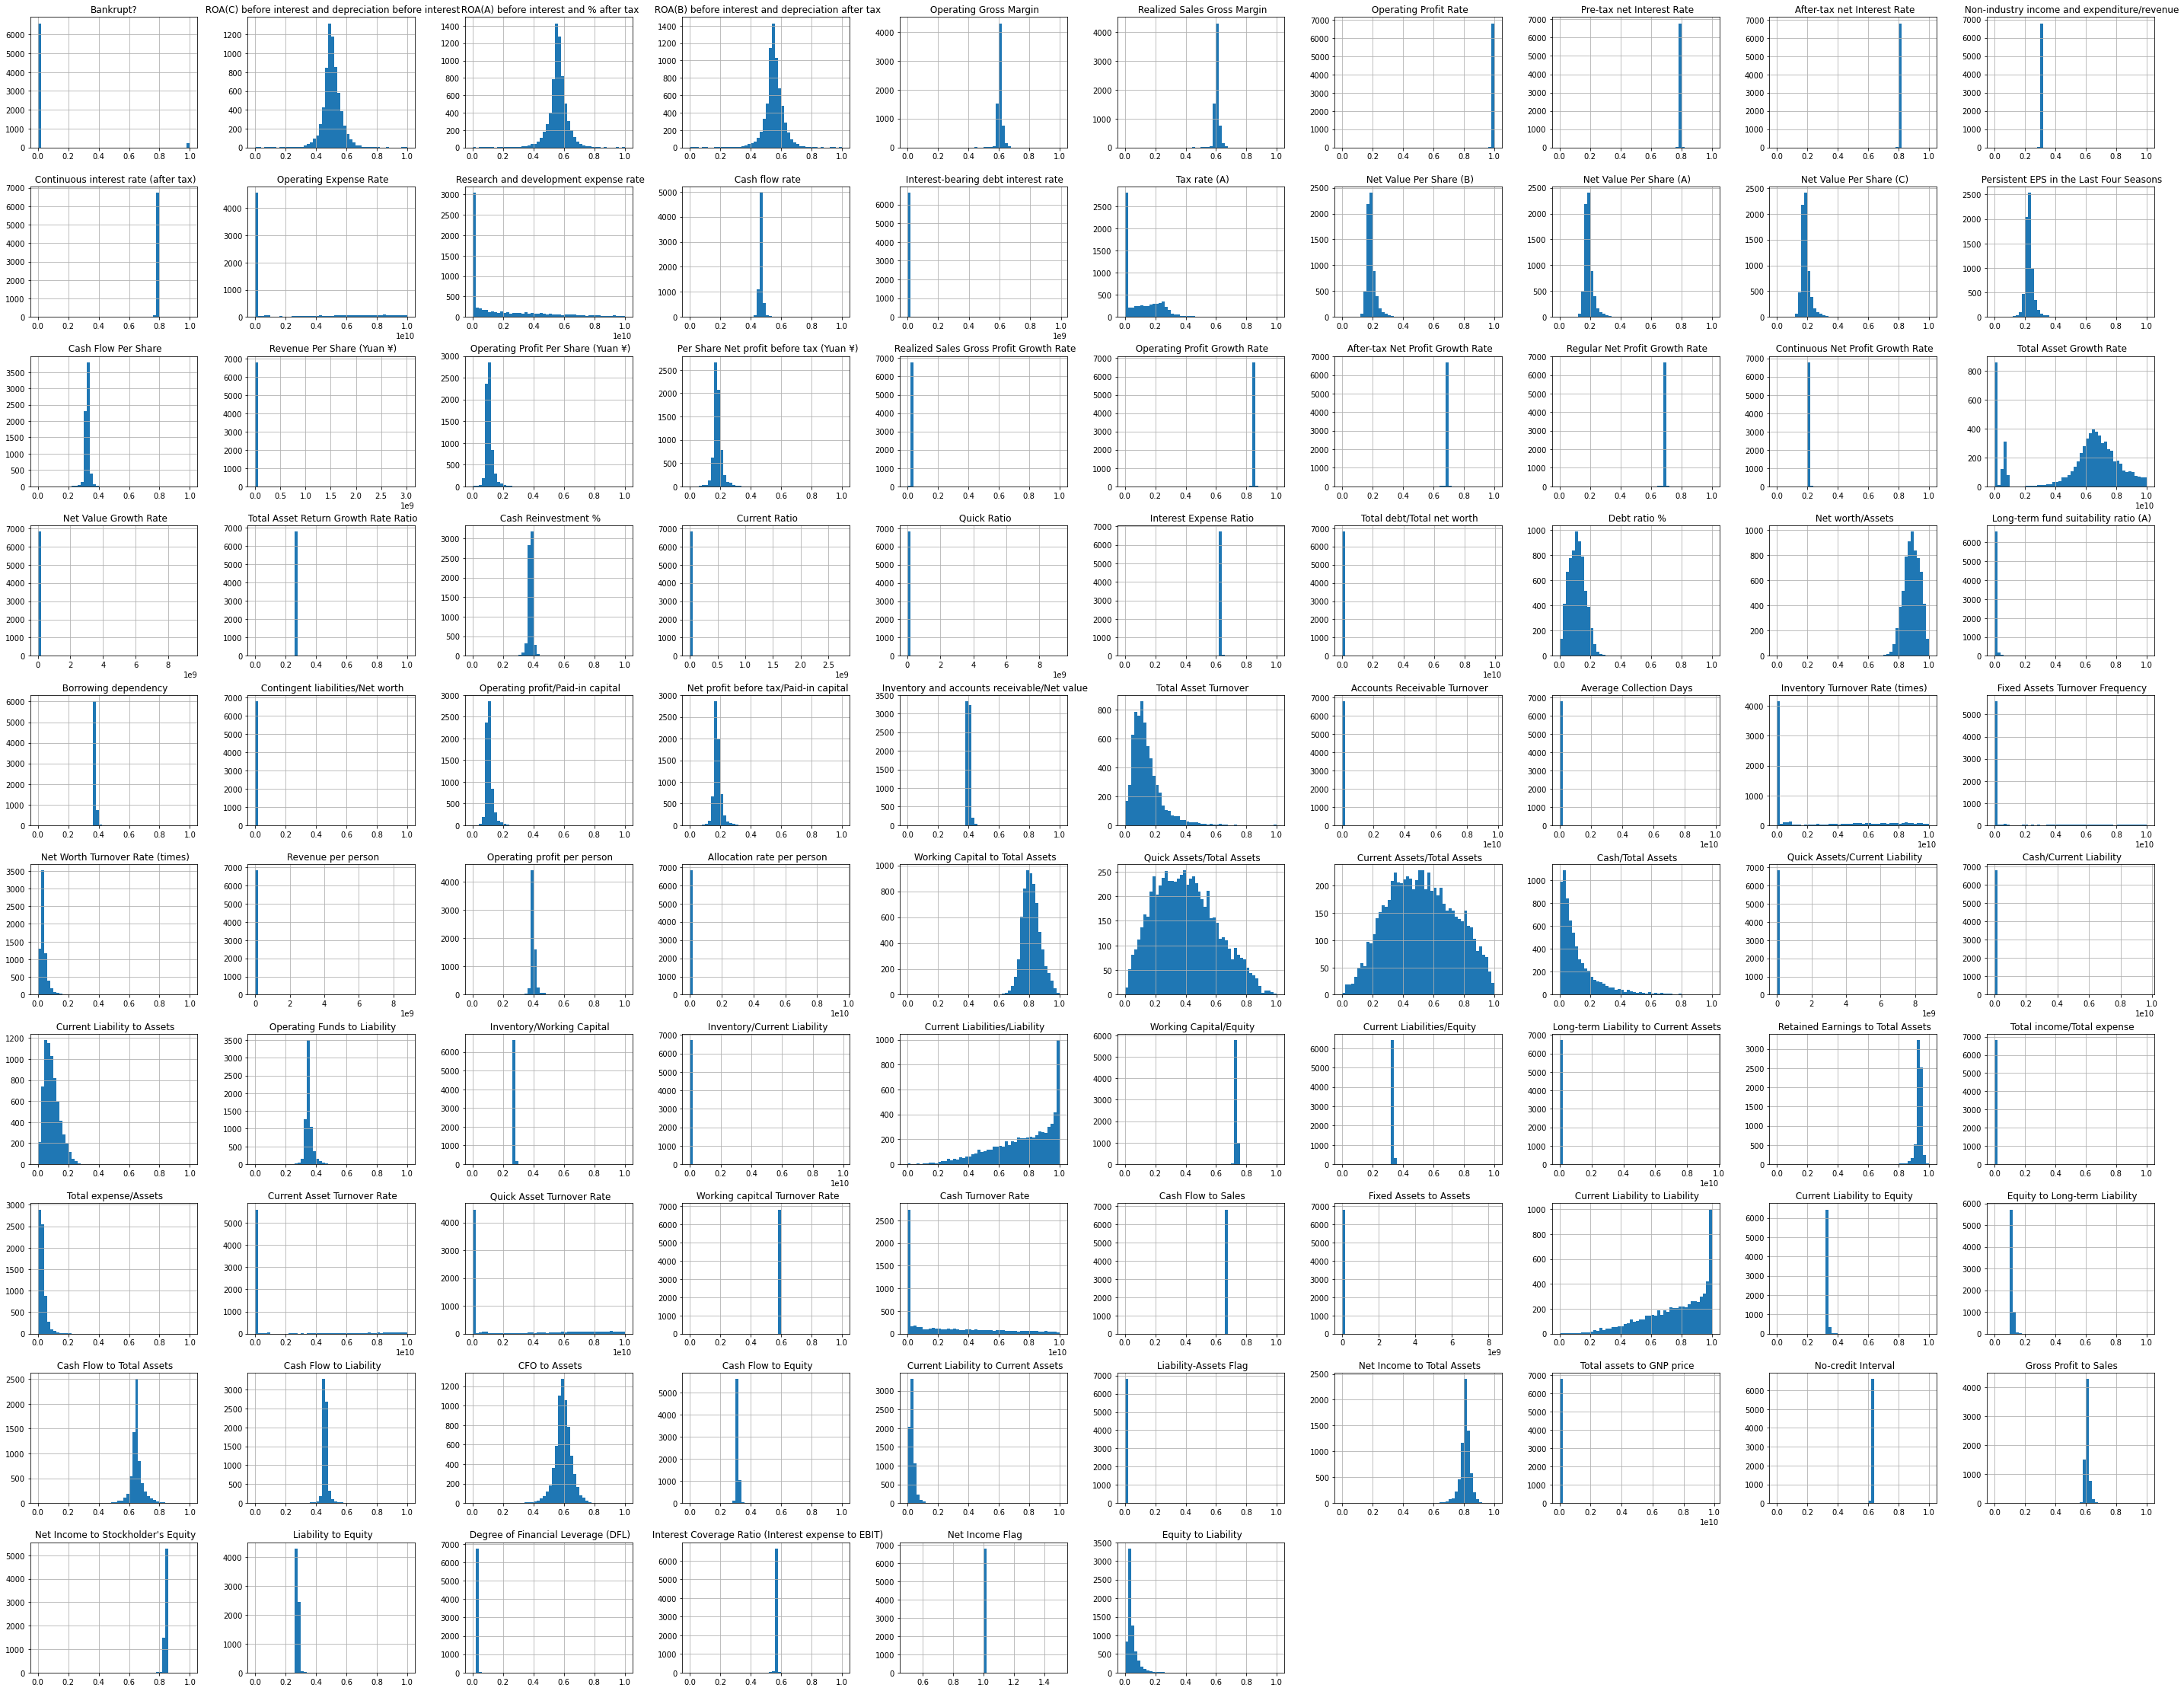

In [5]:
raw_data.hist(figsize = (50,40), bins = 50)
plt.show()

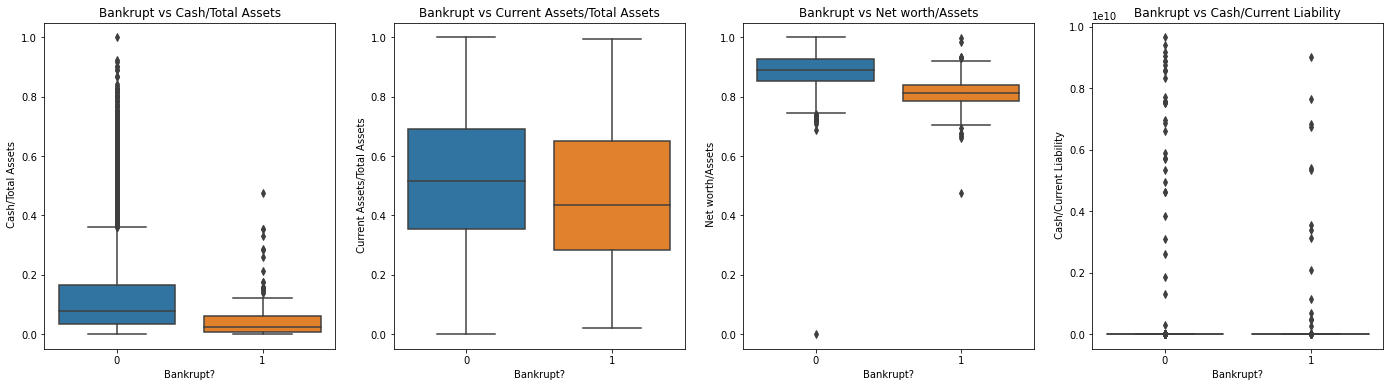

In [6]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=raw_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=raw_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=raw_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=raw_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### Outlier Removal Using IQR

In [7]:
clean_data = raw_data.copy(deep=True)
for col in features_pd:
    clean_data = fcn.remove_outlier(raw_data[col], str(col), raw_data)
clean_data = clean_data.reset_index(drop=True)

### Plots with Outliers Removed

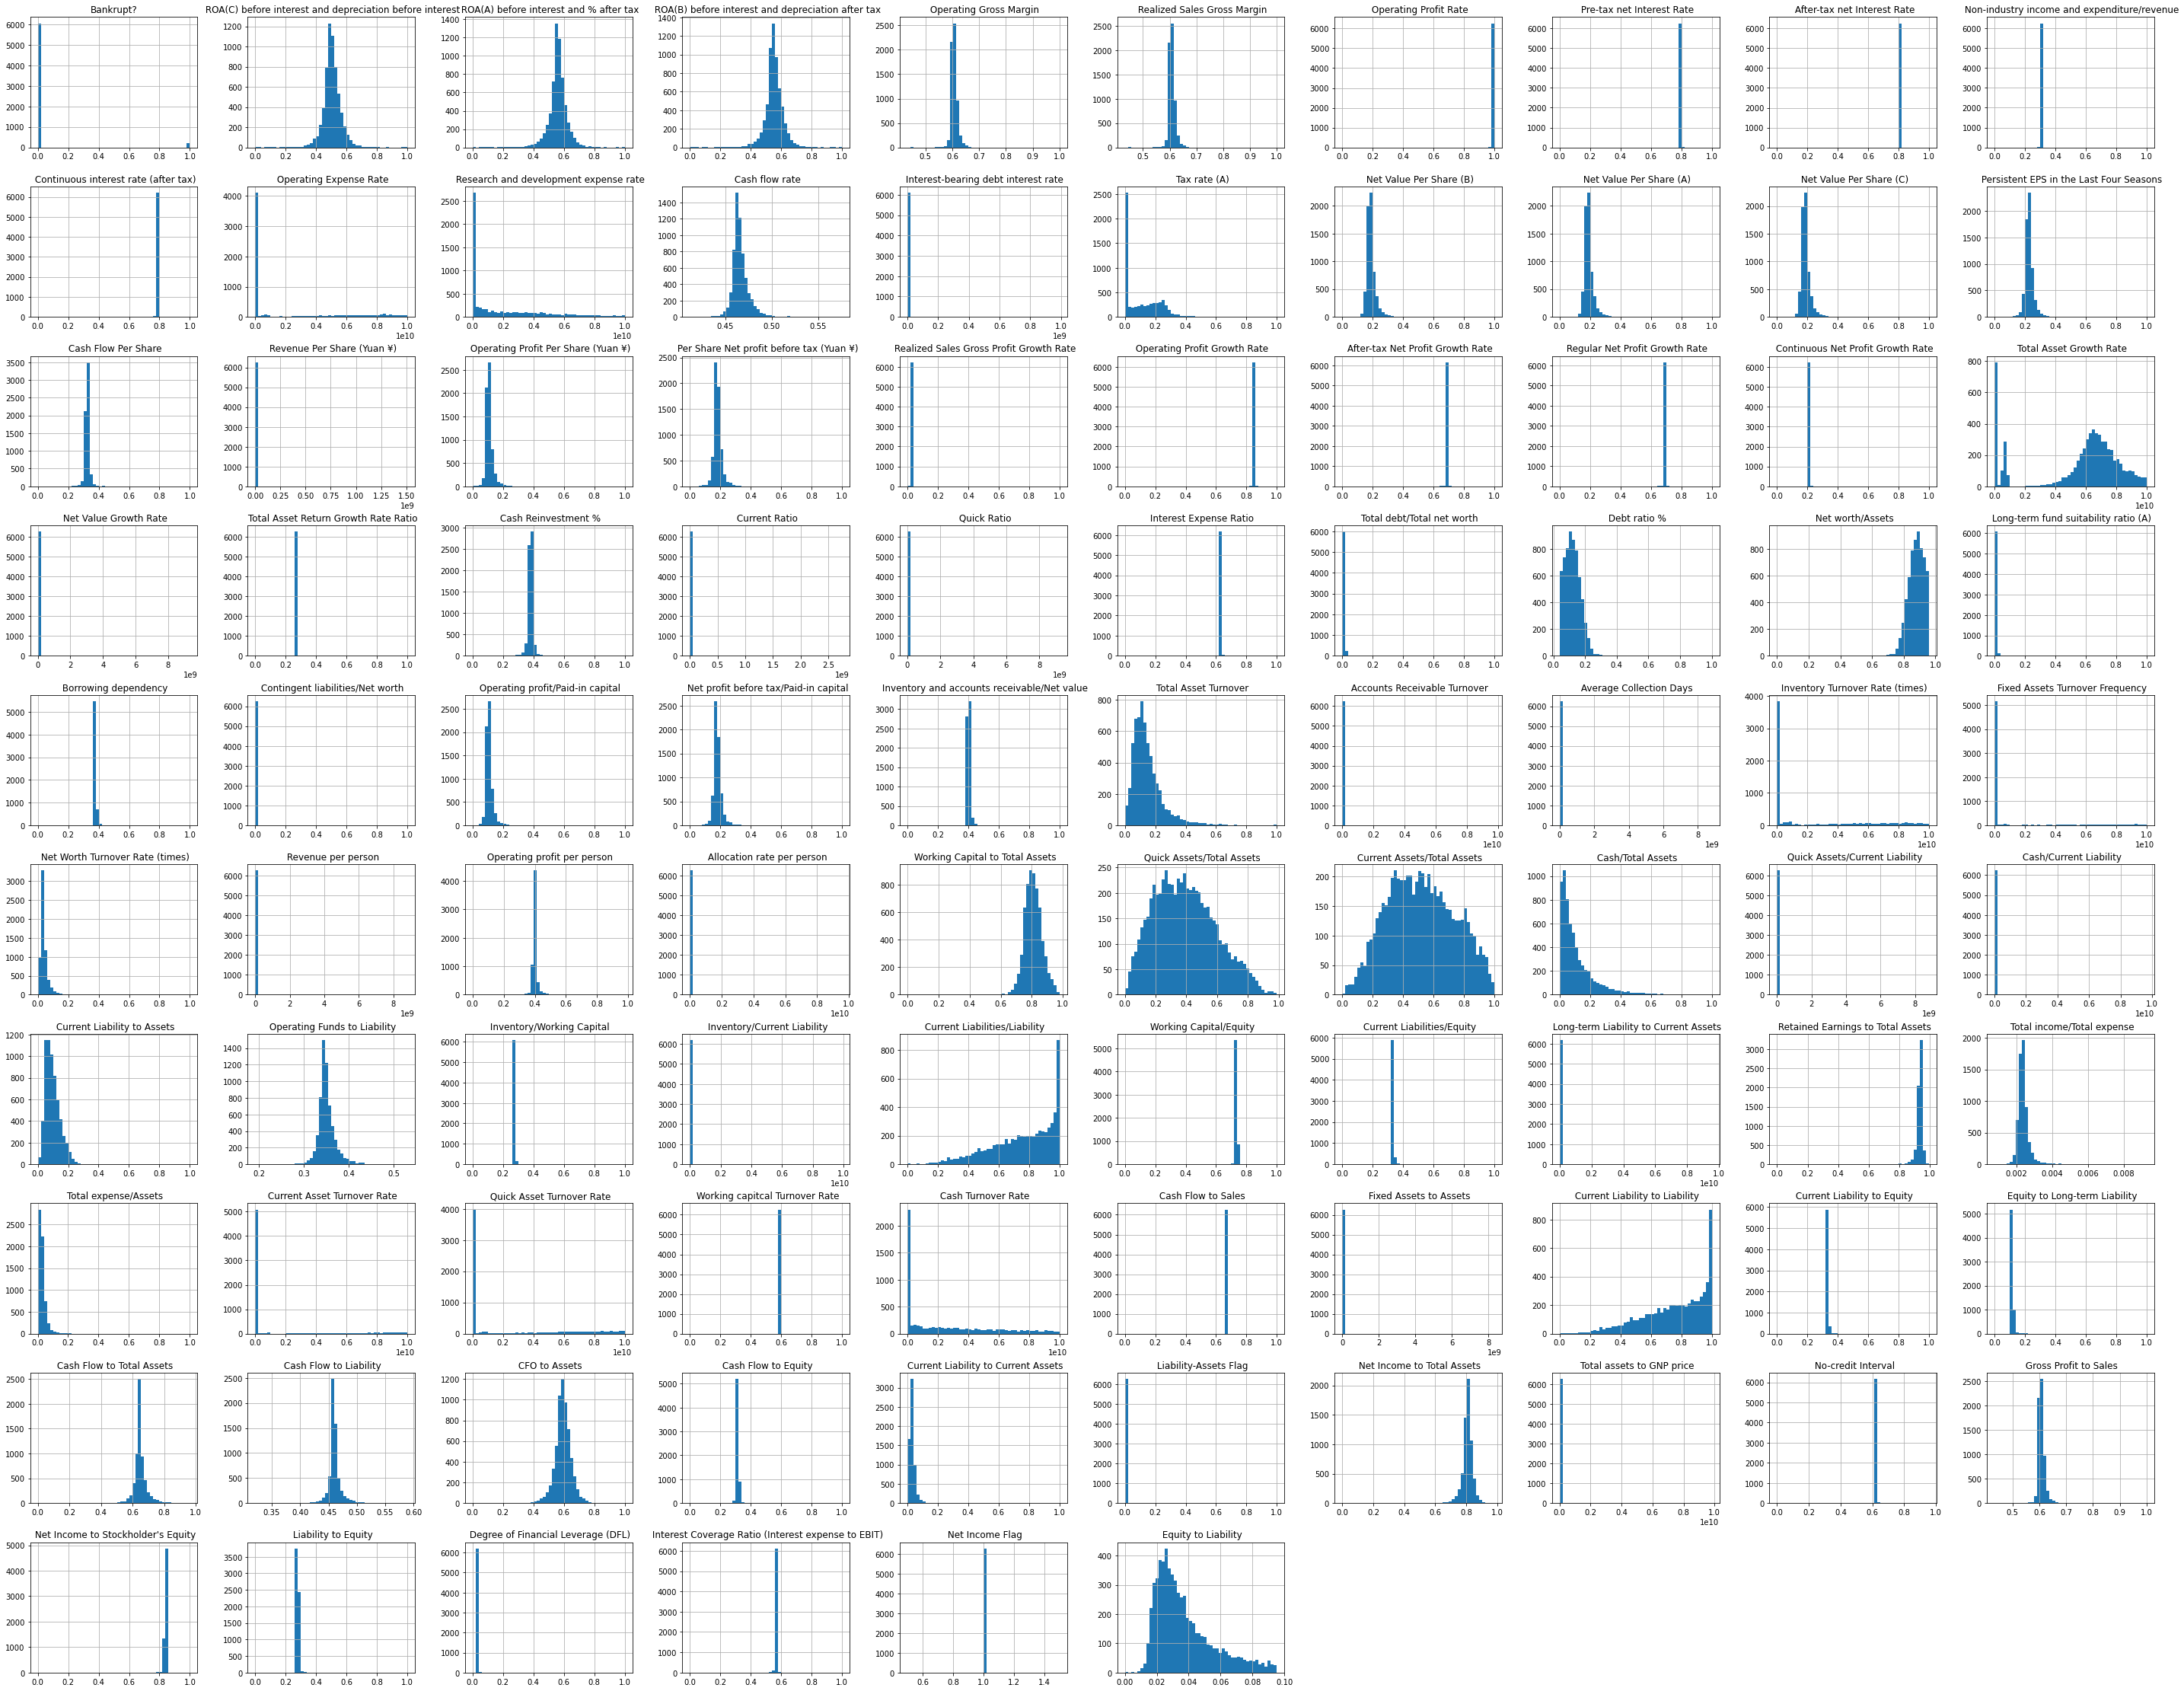

In [8]:
clean_data.hist(figsize = (50,40), bins = 50)
plt.show()

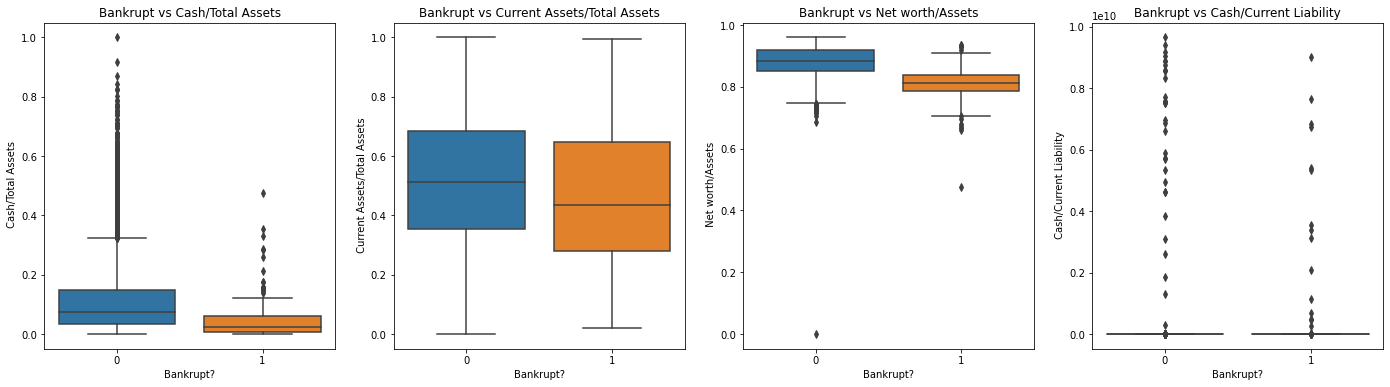

In [9]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=clean_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=clean_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=clean_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=clean_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### SMOTE

In [10]:
minority = clean_data[clean_data["Bankrupt?"] == 1] # Extract minority samoles from data
smt = smote.Smote( minority.to_numpy() ) # Initialize the SMOTE class
oversamples = smt.oversample(N=2600) # Employ SMOTE oversampling


In [11]:
smote_data = clean_data.copy(deep=True) # Cleared from outliers and oversampled
oversamples_pd = pd.DataFrame(oversamples, columns = clean_data.columns)
smote_data = smote_data.append(oversamples_pd)
smote_data = smote_data.reset_index(drop=True)

In [12]:
unstable_smote = (smote_data["Bankrupt?"] == 1).sum()
stable_smote = (smote_data["Bankrupt?"] == 0).sum()
print("Oversampled Data Size:", smote_data.shape[0])
print("Number of Stable Companies:", stable_smote)
print("Number of Unstable Companies (with SMOTE):", unstable_smote)
print("unstable to Stable Ratio: ", unstable_smote/stable_smote, sep="")

Oversampled Data Size: 11938
Number of Stable Companies: 6052
Number of Unstable Companies (with SMOTE): 5886
unstable to Stable Ratio: 0.972571050892267


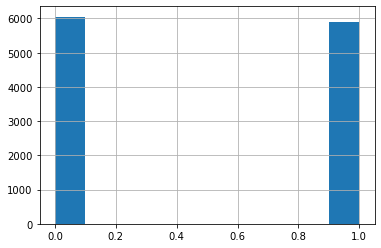

In [13]:
smote_data["Bankrupt?"].hist()
plt.show()

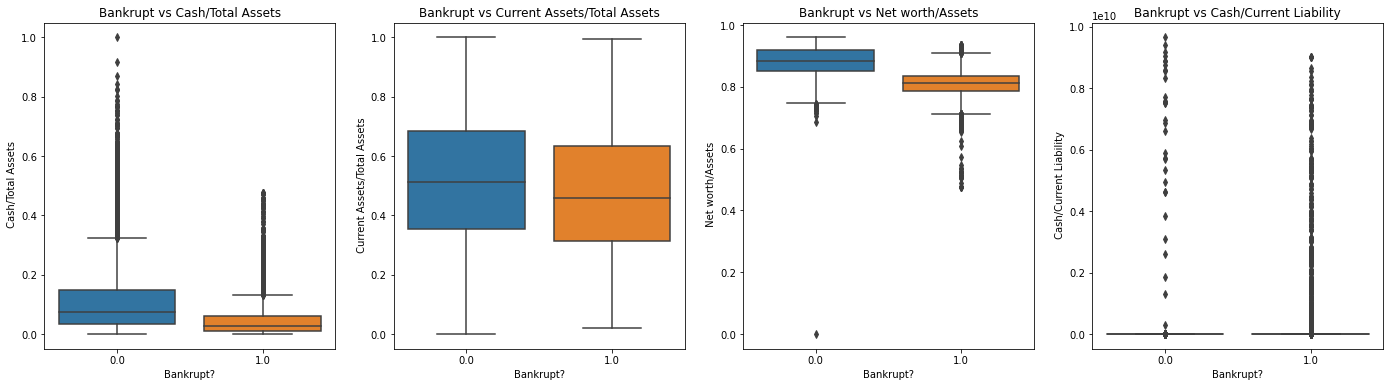

In [21]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=smote_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=smote_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=smote_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=smote_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### Test Train Split

In [22]:
test_ratio = 0.1
#Smote
train_sm, test_sm = fcn.test_train_split(smote_data, test_ratio )
X_train_sm = train_sm.drop(["Bankrupt?"], axis=1)
Y_train_sm = train_sm["Bankrupt?"]
X_test_sm = test_sm.drop(["Bankrupt?"], axis=1)
Y_test_sm = test_sm["Bankrupt?"]
#No Smote
train, test = fcn.test_train_split(clean_data, test_ratio )
X_train = train.drop(["Bankrupt?"], axis=1)
Y_train = train["Bankrupt?"]
X_test = test.drop(["Bankrupt?"], axis=1)
Y_test = test["Bankrupt?"]


### k-Nearest Neighbors Classifier (with and without SMOTE)

In [ ]:
knn_classifier = kNN.k_NN_classifier(X_train.to_numpy(), Y_train.to_numpy() )
Y_test_pd = Y_test.to_numpy()
X_test_pd = X_test.to_numpy()
knn_preds = np.zeros_like(Y_test_pd)
for idx, test in enumerate(X_test_pd):
    knn_preds[idx] = knn_classifier.classify(test)

knn_classifier_sm = kNN.k_NN_classifier(X_train_sm.to_numpy(), Y_train_sm.to_numpy() )
Y_test_sm_pd = Y_test_sm.to_numpy()
X_test_sm_pd = X_test_sm.to_numpy()
knn_sm_preds = np.zeros_like(Y_test_sm_pd)
for idx, test in enumerate(X_test_sm_pd):
    knn_sm_preds[idx] = knn_classifier_sm.classify(test)


In [23]:
print("Confusion Matrix Without SMOTE")
conf_matrix = fcn.confusion_matrix(Y_test_pd, knn_preds, ret = True)

print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )
print("Precision:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]) * 100 )
print()
print("Confusion Matrix With SMOTE")
conf_matrix_sm = fcn.confusion_matrix(Y_test_sm_pd, knn_sm_preds, ret = True)
print("Recall:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[1,0]) * 100 )
print("Precision:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[0,1]) *100 )

Confusion Matrix Without SMOTE
 	1	0 (prediction)
1	1	22
0	2	602
Recall: 33.33333333333333
Precision: 4.3478260869565215

Confusion Matrix With SMOTE
 	1	0 (prediction)
1	569	31
0	95	498
Recall: 85.69277108433735
Precision: 94.83333333333334


### LOGISTIC REGRESSION

In [32]:
class Logistic_regression(object):

    def __init__(self, size) -> None:
        selfb = np.random.rand(size,1)
        pass

    def sigmoid(z):
        sig = 1.0 / (1 + np.exp(-z))
        return sig

    def pred(features, weight):
        y = features@weight
        return Logistic_regression.sigmoid(y)


    def classify(prediction, boundary=0.90):
        return prediction > boundary


    def cost_func(self, features:np.ndarray, labels):
        prediction = Logistic_regression.pred(features,self.b)
        cost = (-labels*np.log(prediction)-(1-labels)*np.log(1-prediction))
        average = cost.sum() / len(features)
        return average

    def gradient_descent( features:np.ndarray, labels, weight, learning_rate = 0.02):
        prediction = Logistic_regression.pred(features, weight)
        mid = prediction - labels
        gradient = features.T@ mid
        gradient = gradient / len(features)
        gradient = gradient * learning_rate
        weight = weight - gradient
        return weight.

In [33]:
log_reg = Logistic_regression(95)
initial_weights = np.random.rand(95,1)
X_train_sm_np = X_train_sm.to_numpy()
Y_train_sm_np = Y_train_sm.to_numpy()
X_test_sm_np = X_test_sm.to_numpy()
Y_test_sm_np = Y_test_sm.to_numpy()
X_train_np = X_train.to_numpy()
Y_train_np = Y_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_test_np = Y_test.to_numpy()
weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), initial_weights)
for idx in range(10000):
    weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), weights)
final_pred =Logistic_regression.pred(X_test_sm_np, weights)
result = Logistic_regression.classify(final_pred)

<ipython-input-32-41936191c3f3>:8: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


In [34]:
conf_matrix_lr = fcn.confusion_matrix(Y_test_sm_np.T, result.T*1, ret = True)
print("Recall:", conf_matrix_lr[0,0]/(conf_matrix_lr[0,0]+conf_matrix_lr[1,0]) * 100 )
print("Precision:", conf_matrix_lr[0,0]/(conf_matrix_lr[0,0]+conf_matrix_lr[0,1]) *100 )

 	1	0 (prediction)
1	555	49
0	486	103
Recall: 53.31412103746398
Precision: 91.88741721854305
